# 커널 서포트 벡터 머신

## XOR 문제

퍼셉트론이나 서포트 벡터 머신과 같은 선형 판별 함수 기반 모형은 다음과 같은 XOR(exclusive OR) 문제를 풀지 못한다는 단점이 있다. 
(exclusive 는 둘중 모두가 둘다 같은 값을 가져야 한다)

| | X2=0 | X2=1 |
|-|-|-|
|X1=0| 0 | 1 |
|X1=1| 1 | 0 | 

이러한 경우에는 선형 판별 평면(decision hyperplane)으로 영역을 나눌 수 없기 때문이다.

In [1]:

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  """


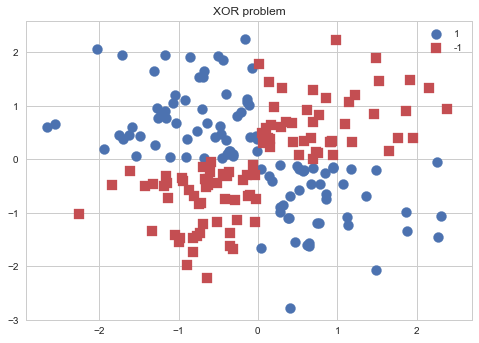

In [2]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='o', label='1', s=100)
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1', s=100)
plt.ylim(-3.0)
plt.legend()
plt.title("XOR problem")
plt.show()

In [3]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y== 1, 0], X[y== 1, 1], c='b', marker='o', label='+1', s=100)
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='r', marker='s', label='-1', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

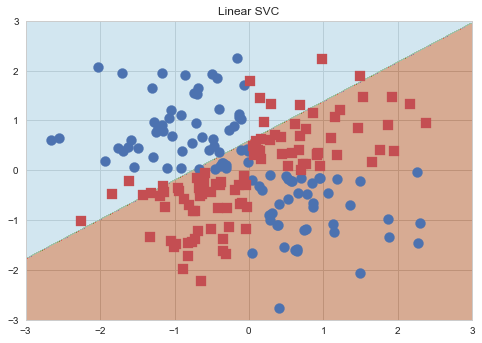

In [4]:
from sklearn.svm import SVC

svc = SVC(kernel="linear").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, "Linear SVC")

## 기저 함수를 사용한 비선형 판별 모형

이러한 경우 도움이 되는 것이 원래의 $D$ 차원 독립 변수 벡터 $x$ 대신 기저 함수(basis function)으로 변환한 $M$ 차원 벡터 $\phi(x)$를 독립 변수 벡터로 사용하는 방법이다.

$$ \phi(\cdot): \mathbf{R}^D \rightarrow \mathbf{R}^M $$

$$ x=(x_1, x_2, \cdots, x_D) \;\;\; \rightarrow \;\;\; \phi(x) = (\phi_1(x), \phi_2(x), \cdots, \phi_M(x)) $$

앞서 XOR 문제를 풀기 위해 다음과 같이 상호 곱(cross-multiplication) 항을 추가한 기저 함수를 사용해 보자.


$$ (x_1, x_2) \;\;\; \rightarrow \;\;\; \phi(x) = (x_1^2, \sqrt{2}x_1x_2, x_2^2) $$

In [5]:
from sklearn.preprocessing import FunctionTransformer ## 기저함수변형 

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1], X[:, 1]**2]).T

X = np.arange(8).reshape(4, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [6]:
FunctionTransformer(basis).fit_transform(X)

array([[  0.        ,   0.        ,   1.        ],
       [  4.        ,   8.48528137,   9.        ],
       [ 16.        ,  28.28427125,  25.        ],
       [ 36.        ,  59.39696962,  49.        ]])

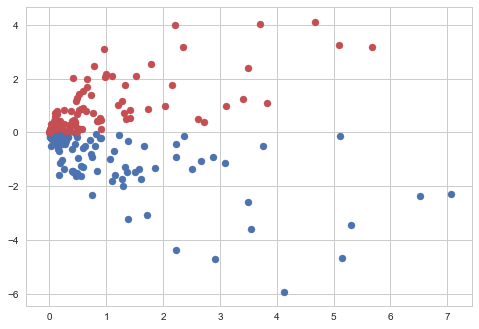

In [7]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor== 1, 0], X_xor2[y_xor== 1, 1], c="b", s=50)
plt.scatter(X_xor2[y_xor==-1, 0], X_xor2[y_xor==-1, 1], c="r", s=50)
plt.show() ## 기저함수를 사용하여 데이터를 변형하였음, SVM은 선형1개로 분리가 가능 

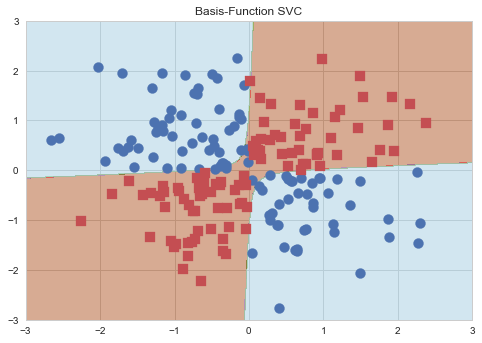

In [8]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([("basis", FunctionTransformer(basis)), ("svc", SVC(kernel="linear"))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, "Basis-Function SVC") ## 파이프라인사용 

## 커널 트릭

커널의 경우 매핑함수 = 기저함수를 이용하여 데이터를 변형하여 구분한다 
문제는 매핑함수 =기저함수를 사람이 직접 정해줘야 한다 
여기서 기저함수는 벡터를 스칼라값으로 변형된다. 

이런 퍼셉트론에서  xx  대신 기저 함수를 적용한  ϕ(x)ϕ(x) 를 사용하면 XOR 문제 등의 비선형 문제를 해결할 수 있다. 그러나 고정된 기저 함수를 사용해야 하므로 문제에 맞는 기저 함수를 찾아야 한다는 단점이 있다.

기저함수를 스스로 찾게하는것은 딥러닝의 기초이다 

서포트 벡터 머신의 경우 목적 함수와 예측 모형은 다음과 같은 dual form으로 표현할 수 있다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0
$$

이 수식에서 $x$를 기저함수 변환으로 $\phi(x)$로 바꾸면

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \phi(x_n)^T \phi(x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n \phi(x_n)^T \phi(x) - w_0
$$

이 된다. 즉 모든 기저함수는 $\phi(x_i)^T\phi(x_j)$의 형태로만 사용되며 독립적으로 사용되지 않는다.

따라서 두 개의 변환된 독립 변수 벡터를 내적(inner product) 한 값 $\phi(x_i)^T\phi(x_j)$를 하나의 함수로 나타낼 수 있다.

$$ k(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

이러한  함수를 커널(kernel)이라고 한다.

대응하는 기저함수가 존재할 수만 있다면 기저함수를 먼저 정의하고 커널을 정의하는 것이 아니라 커널을 먼저 정의해도 상관없다.  

## 커널의 의미

서포트 벡터 머신의 목적 함수와 예측 모형은 커널을 사용하여 표현하면 다음과 같다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m k(x_n, x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n k(x_n, x) - w_0
$$

커널을 사용하지 않는 경우 $ k(x, y) = x^Ty $라는 점을 고려하면 커널은 다음과 같은 특징을 보인다.

* $x$와 $y$가 동일한 벡터일 때 가장 크고
* 두 벡터간의 거리가 멀어질 수록 작아진다.

즉, 두 표본 데이터 간의 유사도(similarity)를 측정하는 기준으로 볼 수도 있다. 

## 커널 사용의 장점

커널을 사용하면 베이시스 함수를 하나씩 정의하는 수고를 덜 수 있을뿐더러 변환과 내적에 들어가는 계산량이 줄어든다. 예를 들어, 다음과 같은 기저함수의 경우

$$ \phi(x_i) = \phi([x_{i,1}, x_{i,2}]) = (x_{i,1}^2, \sqrt{2}x_{i,1}x_{i,2}, x_{i,2}^2) $$

커널 방법을 쓰지 않을 경우에 $ \phi(x_i)^T \phi(x_j) $를 계산하려면 $4 + 4 + 3 = 11$ 번의 곱셈을 해야 한다.

* $\phi(x_1)$ 계산 : 곱셈 4회
* $\phi(x_2)$ 계산 : 곱셈 4회
* 내적: 곱셈 3회

그런데 이 기저함수는 다음과 같은 커널로 대체가능하다.

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2)^2 \\
&=& (x_{1,1}x_{2,1} + x_{1,2}x_{2,2})^2 \\
&=& x_{1,1}^2x_{2,1}^2 + 2x_{1,1}x_{2,1}x_{1,2}x_{2,2} + x_{1,2}^2y_{2,2}^2 \\
&=& (x_{1,1}^2, \sqrt{2}x_{1,1}x_{1,2}, x_{1,2}^2)  (x_{2,1}^2, \sqrt{2}x_{2,1}x_{2,2}, x_{2,2}^2)^T \\
&=& \phi(x_1)^T \phi(x_2)
\end{eqnarray}
$$


커널을 사용하면  $ \phi(x_1)^T \phi(x_2) $ 을 계산하는데 $2 + 1 = 3$ 번의 곱셈이면 된다.
 
* $x_1^Tx_2$: 곱셈 2회
* 제곱: 곱셈 1회

## 많이 사용되는 커널

다음과 같은 커널들이 많이 사용되는 커널들이다. 이 커널들은 대부분 기저함수로 변환하였을 때 무한대의 차원을 가지는 기저 함수가 된다. 따라서 대부분의 비선형성을 처리할 수 있다.


* 커널을 사용하지 않는 경우

$$ k(x_1, x_2) = x_1^Tx_2 $$


* 다항 커널 (Polynomial Kernel) ->내적 = 유사도(각도), 즉, 새로운 입력값이 들어올때 분류의 기준으로 각도로 정한다 

$$ k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d $$


* RBF(Radial Basis Function) 또는 가우시안 커널 (Gaussian Kernel) -> 거리는 similarity와 반비례한다, 거리를 구하고 역수를 곱한다. 

$$ k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right) $$


* 시그모이드 커널 (Sigmoid Kernel)

$$ k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta) $$


앞에서 사용한 기저함수는 $\gamma = 1, \theta= 0, d=2$ 인 다항 커널임을 알 수 있다.

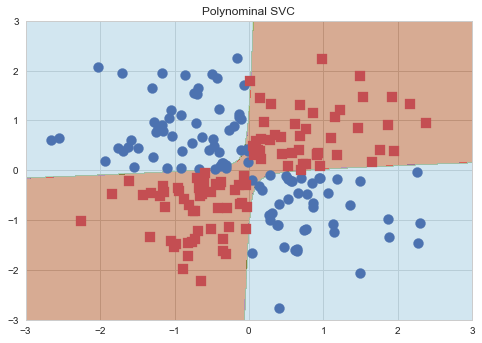

In [9]:
polysvc = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_xor, y_xor) ## 다항커널 사용 
plot_xor(X_xor, y_xor, polysvc, "Polynominal SVC")

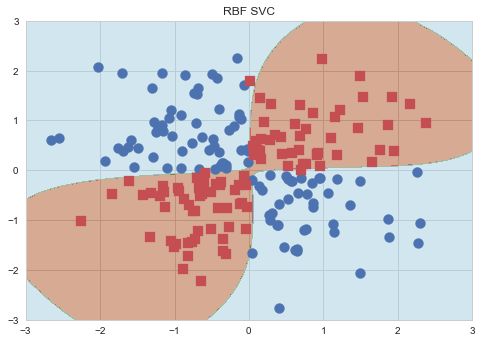

In [10]:
rbfsvc = SVC(kernel="rbf").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, rbfsvc, "RBF SVC") 
## 서포트 백터들은 경계선 주변에 있다. 새로운 입력값이 주어졌을때 서포트벡터들과의 거리를 잰다. 거리가 가까운 분류값으로 분류한다 

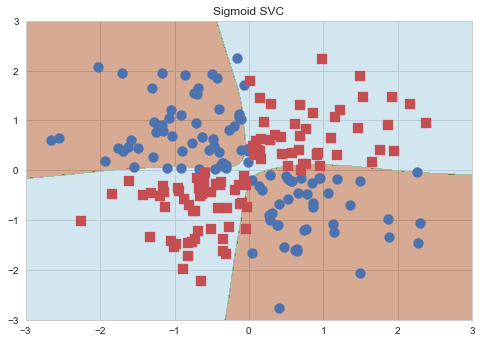

In [11]:
sigmoidsvc = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, sigmoidsvc, "Sigmoid SVC")

## 커널 파라미터

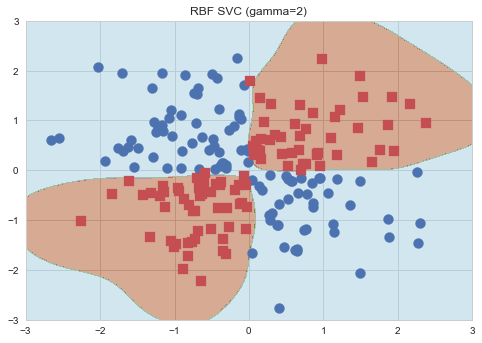

In [12]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=2).fit(X_xor, y_xor), "RBF SVC (gamma=2)")

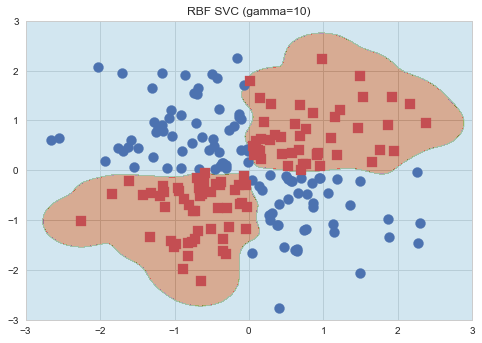

In [13]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=10).fit(X_xor, y_xor), "RBF SVC (gamma=10)")

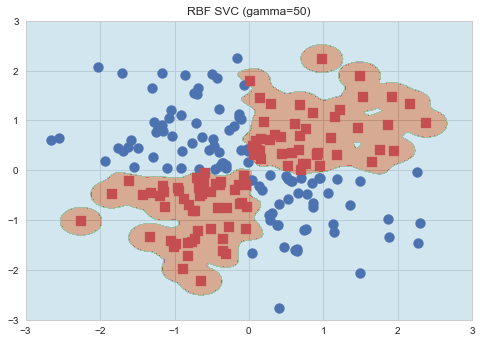

In [14]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVC (gamma=50)")

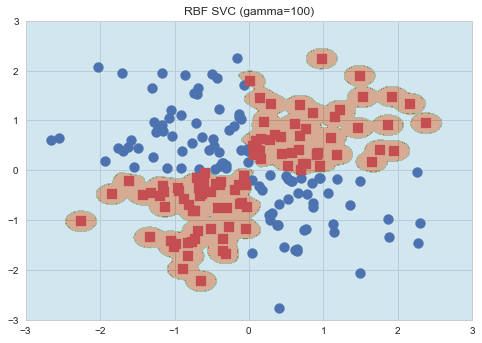

In [15]:
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=100).fit(X_xor, y_xor), "RBF SVC (gamma=100)")

## 예 : Iris 

In [16]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y==0, 0], X[y==0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y==2, 0], X[y==2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()

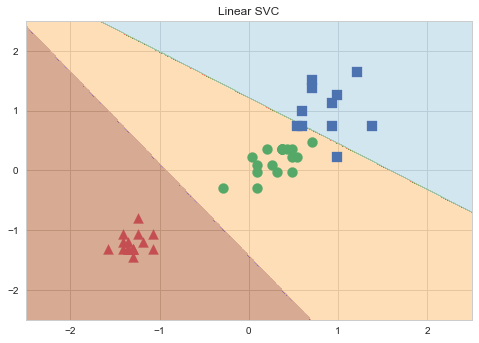

In [17]:
model = SVC(kernel='linear').fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "Linear SVC")

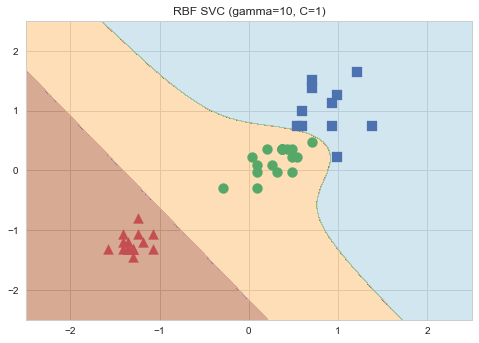

In [18]:
model = SVC(kernel='poly', random_state=0, gamma=10, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "RBF SVC (gamma=10, C=1)")

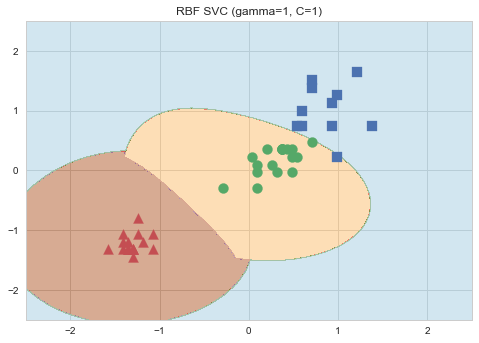

In [19]:
model = SVC(kernel='rbf', random_state=0, gamma=1, C=1.0).fit(X_test_std, y_test)
plot_iris(X_test_std, y_test, model, "RBF SVC (gamma=1, C=1)")